In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

training_data_path = '../training_data/loaded_data'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]
    )

In [3]:
with open(os.path.join(training_data_path, 'element_spec'), 'rb') as element_spec_file:
    element_spec = pickle.load(element_spec_file)

dataset = tf.data.experimental.load(
    training_data_path, element_spec, compression='GZIP'
)

dataset = dataset.map(lambda e: (e[0], (e[1], e[2], e[3]))).cache().shuffle(10000)

dataset_test = dataset.take(100)
dataset_val = dataset.skip(100).take(2000).batch(32)
dataset_train = dataset.skip(2100)


dataset_train = dataset_train.batch(32).prefetch(1)

In [4]:
import model
image_model_v2 = model.build_model_v2()
#image_model_v1 = model.build_model()

In [5]:
image_model_v2.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.01),
    loss = 'mse'
)
# image_model_v1.compile(
#     optimizer=keras.optimizers.Nadam(),
#     loss = 'mse'
# )
keras.utils.plot_model(image_model_v2, to_file='model_v2_plot.png', show_shapes=True, show_layer_names=True)
# keras.utils.plot_model(image_model_v1, to_file='model_v1_plot.png', show_shapes=True, show_layer_names=True)
pass

In [6]:
image_model_v2.fit(dataset_train, epochs=500, validation_data=dataset_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
                keras.callbacks.ModelCheckpoint('v2_checkpoints/', save_best_only=True)])


Epoch 1/500
699/699 [==============================] - 125s 130ms/step - loss: 0.1015 - conv2d_24_loss: 0.0361 - conv2d_37_loss: 0.0367 - conv2d_50_loss: 0.0288 - val_loss: 0.0997 - val_conv2d_24_loss: 0.0363 - val_conv2d_37_loss: 0.0350 - val_conv2d_50_loss: 0.0284
Epoch 2/500
699/699 [==============================] - 91s 129ms/step - loss: 0.0802 - conv2d_24_loss: 0.0277 - conv2d_37_loss: 0.0283 - conv2d_50_loss: 0.0242 - val_loss: 0.0774 - val_conv2d_24_loss: 0.0266 - val_conv2d_37_loss: 0.0274 - val_conv2d_50_loss: 0.0234
Epoch 3/500
699/699 [==============================] - 71s 102ms/step - loss: 0.0675 - conv2d_24_loss: 0.0232 - conv2d_37_loss: 0.0237 - conv2d_50_loss: 0.0207 - val_loss: 0.0927 - val_conv2d_24_loss: 0.0316 - val_conv2d_37_loss: 0.0340 - val_conv2d_50_loss: 0.0272
Epoch 4/500
699/699 [==============================] - 74s 106ms/step - loss: 0.0608 - conv2d_24_loss: 0.0207 - conv2d_37_loss: 0.0213 - conv2d_50_loss: 0.0188 - val_loss: 0.0873 - val_conv2d_24_loss: 

In [7]:
# image_model_v1.fit(dataset_train, epochs=100, validation_data=dataset_val,
#     callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
#                 keras.callbacks.ModelCheckpoint('v1_checkpoints/', save_best_only=True)])


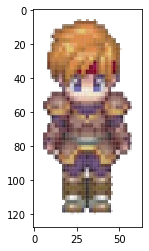

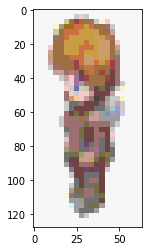

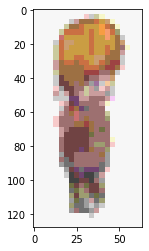

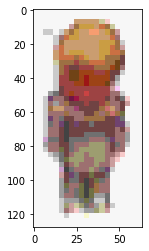

In [24]:



import cv2
from pyxelate.pyxelate import Pyx, Pal
image=cv2.imread('../sample.png', cv2.IMREAD_COLOR)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image, (64, 128))
image=image/255

plt.imshow(image)
plt.show()
(left, right, back) = image_model_v2.predict(np.array([image]))
cv2.imwrite('../result.png', left)
plt.imshow(pixelate(left.squeeze(), 3, 45))
plt.show()
plt.imshow(pixelate(right.squeeze(), 3, 45))
plt.show()
plt.imshow(pixelate(back.squeeze(),3, 45))
plt.show()

In [1]:

def pixelate(image, size = 2, color_div = 10):
    image = image.squeeze()
    height, width, _ = image.shape
    image = np.array(image)
    for sh in range(0, height, size):
        for sw in range(0, width, size):
            avg = np.mean(image[sh:sh+size, sw:sw+size], axis = (0, 1))
            image[sh:sh+size, sw:sw+size, :] = avg
    image = (image*255).astype(np.uint16)
    image = image // color_div * color_div + color_div//2
    image = image/255
    image = np.clip(image, 0., 1.)
    return image

for inp, (left, right, back) in dataset_test.take(2):
    (gen_left, gen_right, gen_back) = keras.models.load_model('best_image_v2_model.h5').predict(np.array([inp]))
    plt.imshow(inp)
    plt.show()
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 2, 1)
    plt.imshow(right)
    plt.subplot(3, 2, 2)
    plt.imshow(pixelate(gen_right, 3, 45))
    plt.subplot(3, 2, 3)
    plt.imshow(left)
    plt.subplot(3, 2, 4)
    plt.imshow(pixelate(gen_left, 3, 45))
    plt.subplot(3, 2, 5)
    plt.imshow(back)
    plt.subplot(3, 2, 6)
    plt.imshow(pixelate(gen_back, 3, 45))
    plt.show()


NameError: name 'dataset_test' is not defined

In [18]:
image_model_v2.save('best_image_v2_model.h5')

In [20]:
keras.models.load_model('best_image_v2_model.h5')